# Dog breed classifier

We selected 9 dog breeds for this project, and use 13599 pictures (about 1500 for each breed) for training and 1447 pitcures for testing.  
<br/>In this project, our method is to use bottleneck featuers from VGG16 and train by only the top layers because it's computational efficient.

In [10]:
import keras

In [11]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.utils import np_utils
from glob import glob
import math

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import keras.backend as K
K.clear_session()

We choose input pictures size as 150x150.

In [14]:
nrow = 150
ncol = 150

# Load VGG16 as our base model.

In [15]:
input_shape = (nrow, ncol,3)
base_model = applications.VGG16(include_top=False, weights='imagenet',input_shape=input_shape)  

# Load datas
Rescale data values from 0 to 1, and set class_mode=None, shuffle=False.
<br/>We tried to set class_mode='categorical' and shuffle=True, but the accracy we got from that case wasn't as good as this one.

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
batch_size = 32
train_data_dir = 'Images/train'
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,  
                        class_mode=None,shuffle=False)


ntrain_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  
predict_size_train = int(math.ceil(ntrain_samples/batch_size)) 

Found 13599 images belonging to 9 classes.


In [17]:
test_data_dir = 'Images/test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
batch_size = 32
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,  
                        class_mode=None,shuffle=False)
ntest_samples = len(test_generator.filenames)  
predict_size_test = int(math.ceil(ntest_samples / batch_size))  

Found 1447 images belonging to 9 classes.


# Display the image

In [30]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray') 
    else:
        # Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

Found 13599 images belonging to 9 classes.


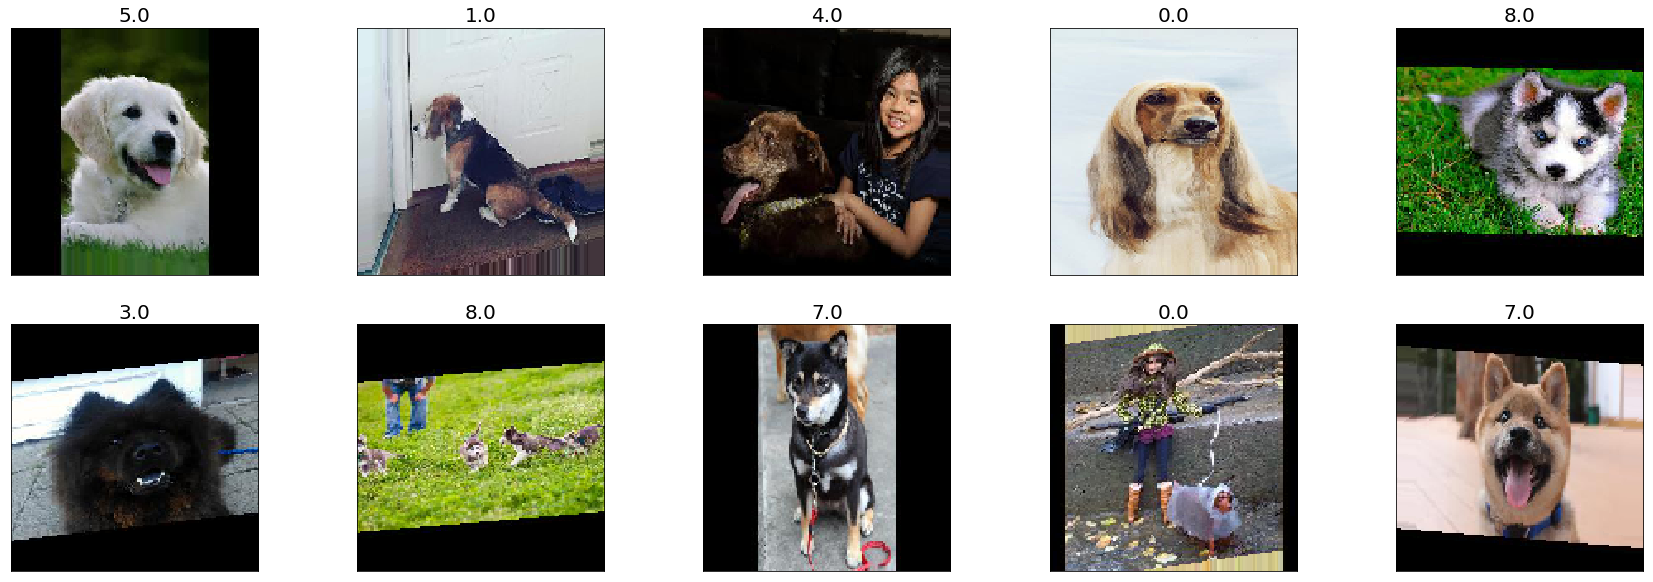

In [44]:
train_generator_display=train_datagen.flow_from_directory(
                            train_data_dir,
                            target_size=(nrow,ncol),
                            batch_size=batch_size,  
                            class_mode='binary',shuffle=True)
X,y=train_generator_display.next() 
plt.figure(figsize=(30,10)) 
nplot = 10
for i in range(nplot):
    plt.subplot(2,5,i+1)
    plt.title(y[i],fontsize=20)
    disp_image(X[i,:,:,:])

# Get bottleneck features
This took a long time since the input scale is large.
<br/>Use predict_generator to get bottleneck features and save them for later use.

In [18]:
#generate bottle neck features
bottleneck_features_train = base_model.predict_generator(train_generator, predict_size_train)

#save bottle neck features for training data
np.save('Images/bottleneck_features_train2.npy', bottleneck_features_train) 

In [19]:
bottleneck_features_test = base_model.predict_generator(test_generator, predict_size_test)

#save bottle neck features for test data
np.save('Images/bottleneck_features_test2.npy', bottleneck_features_test)  

# Create a different data generator for top layers 
Set class_mode='catrgorical' this time. 

In [21]:
from keras.utils.np_utils import to_categorical
datagen_top = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
batch_size = 32
train_generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(nrow,ncol),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
  
nb_train_samples = len(train_generator_top.filenames)  
num_classes = len(train_generator_top.class_indices)  
   
train_data = np.load('Images/bottleneck_features_train2.npy')  
   
#get the class lebels for the training data, in the original order  
train_labels = train_generator_top.classes  
   
#convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  

Found 13599 images belonging to 9 classes.


In [22]:
test_generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(nrow,ncol),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_test_samples = len(test_generator_top.filenames)  
   
test_data = np.load('Images/bottleneck_features_test2.npy')  
   
test_labels = test_generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 1447 images belonging to 9 classes.


In [23]:
train_data.shape[1:]

(4, 4, 512)

# Build top layers
We use relu and l2 regularizer for hidden layers, and softmax for output layer.

In [24]:
from keras import regularizers
modelVGG16=Sequential()
modelVGG16.add(Flatten(input_shape=train_data.shape[1:]))  
modelVGG16.add(Dense(256, activation='relu'))  
modelVGG16.add(Dropout(0.5))
modelVGG16.add(Dense(64,kernel_regularizer=regularizers.l2(0.05)))
modelVGG16.add(Dropout(0.5))
modelVGG16.add(Dense(num_classes, activation='softmax'))  
modelVGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 2,114,441
Trainable params: 2,114,441
Non-trainable params: 0
_________________________________________________________________


Compile modelVGG16 and train the model.
<br/>We use ModelCheckerpoint to save best model during training, and TerminateOnNan to stop training if loss is Nan.

In [25]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ModelCheckpoint
opt=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
modelVGG16.compile(optimizer=opt,  
              loss='categorical_crossentropy', metrics=['accuracy'])  
epochs=100
top_model_weights_path = 'bottleneck_model_1.h5'
checkpointer = ModelCheckpoint(filepath=top_model_weights_path, 
                               verbose=1, save_best_only=True)
EarlyStopping=EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
TerminateOnNaN=TerminateOnNaN()

history = modelVGG16.fit(train_data, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,callbacks=[checkpointer,TerminateOnNaN],verbose=1,  
          validation_data=(test_data, test_labels))  

Train on 13599 samples, validate on 1447 samples
Epoch 1/100
13599/13599 [==============================] - 19s - loss: 7.4032 - acc: 0.1512 - val_loss: 6.9872 - val_acc: 0.1852
Epoch 2/100
13599/13599 [==============================] - 17s - loss: 6.8206 - acc: 0.2066 - val_loss: 6.6315 - val_acc: 0.2377
Epoch 3/100
13599/13599 [==============================] - 20s - loss: 6.4560 - acc: 0.2468 - val_loss: 6.2872 - val_acc: 0.2764
Epoch 4/100
13599/13599 [==============================] - 19s - loss: 6.0967 - acc: 0.2826 - val_loss: 5.9389 - val_acc: 0.3041
Epoch 5/100
13599/13599 [==============================] - 20s - loss: 5.7756 - acc: 0.3134 - val_loss: 5.6232 - val_acc: 0.3207
Epoch 6/100
13599/13599 [==============================] - 21s - loss: 5.4656 - acc: 0.3339 - val_loss: 5.3260 - val_acc: 0.3525
Epoch 7/100
13599/13599 [==============================] - 20s - loss: 5.1734 - acc: 0.3616 - val_loss: 5.0582 - val_acc: 0.3753
Epoch 8/100
13599/13599 [=======================

13599/13599 [==============================] - 16s - loss: 2.3901 - acc: 0.5526 - val_loss: 2.5001 - val_acc: 0.4976
Epoch 28/100
13599/13599 [==============================] - 16s - loss: 2.3314 - acc: 0.5629 - val_loss: 2.4486 - val_acc: 0.4997
Epoch 29/100
13599/13599 [==============================] - 16s - loss: 2.2688 - acc: 0.5684 - val_loss: 2.4017 - val_acc: 0.4955
Epoch 30/100
13599/13599 [==============================] - 16s - loss: 2.2138 - acc: 0.5746 - val_loss: 2.3607 - val_acc: 0.4983
Epoch 31/100
13599/13599 [==============================] - 16s - loss: 2.1647 - acc: 0.5765 - val_loss: 2.3029 - val_acc: 0.4997
Epoch 32/100
13599/13599 [==============================] - 16s - loss: 2.1154 - acc: 0.5791 - val_loss: 2.2678 - val_acc: 0.5003
Epoch 33/100
13599/13599 [==============================] - 16s - loss: 2.0669 - acc: 0.5872 - val_loss: 2.2326 - val_acc: 0.5017
Epoch 34/100
13599/13599 [==============================] - 16s - loss: 2.0272 - acc: 0.5906 - val_loss

13599/13599 [==============================] - 20s - loss: 1.4505 - acc: 0.6715 - val_loss: 1.7762 - val_acc: 0.5211
Epoch 55/100
13599/13599 [==============================] - 19s - loss: 1.4297 - acc: 0.6679 - val_loss: 1.7681 - val_acc: 0.5232
Epoch 56/100
13599/13599 [==============================] - 19s - loss: 1.4099 - acc: 0.6772 - val_loss: 1.7371 - val_acc: 0.5321
Epoch 57/100
13599/13599 [==============================] - 18s - loss: 1.3892 - acc: 0.6818 - val_loss: 1.7543 - val_acc: 0.5121
Epoch 58/100
13599/13599 [==============================] - 18s - loss: 1.3820 - acc: 0.6785 - val_loss: 1.7306 - val_acc: 0.5287
Epoch 59/100
13599/13599 [==============================] - 20s - loss: 1.3579 - acc: 0.6867 - val_loss: 1.7180 - val_acc: 0.5342
Epoch 60/100
13599/13599 [==============================] - 19s - loss: 1.3403 - acc: 0.6868 - val_loss: 1.7134 - val_acc: 0.5238
Epoch 61/100
13599/13599 [==============================] - 19s - loss: 1.3295 - acc: 0.6933 - val_loss

13599/13599 [==============================] - 18s - loss: 1.0503 - acc: 0.7545 - val_loss: 1.5966 - val_acc: 0.5342
Epoch 85/100
13599/13599 [==============================] - 18s - loss: 1.0400 - acc: 0.7586 - val_loss: 1.5923 - val_acc: 0.5411
Epoch 86/100
13599/13599 [==============================] - 20s - loss: 1.0352 - acc: 0.7554 - val_loss: 1.5785 - val_acc: 0.5404
Epoch 87/100
13599/13599 [==============================] - 16s - loss: 1.0215 - acc: 0.7555 - val_loss: 1.5973 - val_acc: 0.5321
Epoch 88/100
13599/13599 [==============================] - 16s - loss: 1.0063 - acc: 0.7623 - val_loss: 1.5761 - val_acc: 0.5384
Epoch 89/100
13599/13599 [==============================] - 16s - loss: 1.0074 - acc: 0.7652 - val_loss: 1.5979 - val_acc: 0.5328
Epoch 90/100
13599/13599 [==============================] - 16s - loss: 0.9961 - acc: 0.7674 - val_loss: 1.5982 - val_acc: 0.5328
Epoch 91/100
13599/13599 [==============================] - 16s - loss: 0.9856 - acc: 0.7687 - val_loss

Save the final weights in case it's needed.

In [26]:
modelVGG16.save('bottleneck_model_1_final.h5')

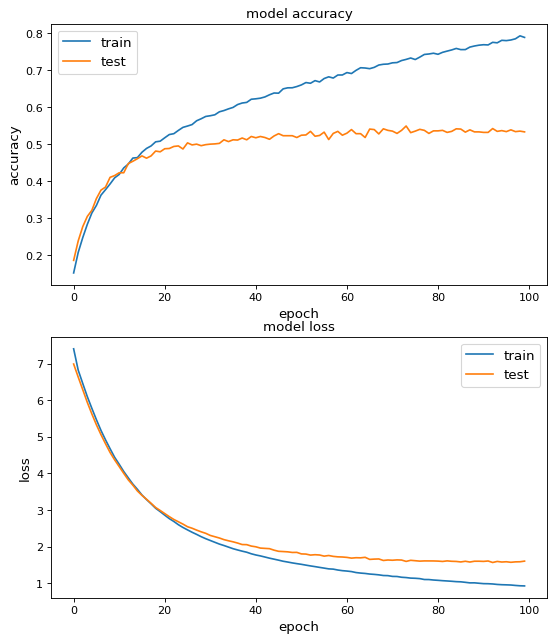

In [27]:
plt.figure(figsize=(8,9.5),dpi=80, facecolor='w', edgecolor='k')  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy',fontsize=12)  
plt.ylabel('accuracy',fontsize=12)  
plt.xlabel('epoch',fontsize=12)  
plt.legend(['train', 'test'], loc='best',fontsize=12)  
   
# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss',fontsize=12)  
plt.ylabel('loss',fontsize=12)  
plt.xlabel('epoch',fontsize=12)  
plt.legend(['train', 'test'], loc='best',fontsize=12)  
plt.show()  

Loss and accuracy of test data saturated as training goes on.
<br/><br/>We've tried other models with different regularizer penalties or higher dropout, but the results weren't as good as this model.

# References

1. [Building Powerful Image Classification Models Using Very Little Data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
<br/><br/>
2. [Using Bottleneck Features for Multi-Class Classification in Keras and TensorFlow](http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html)
<br/><br/>
3. [Dog Breed Prediction with Convolutional Neural Networks](https://github.com/jeremyjordan/dog-breed-classifier/blob/master/dog_app.ipynb)